# Precharattana Model (Optimized)
Here we follow the apporach in `11111.py` and optimize the Precharattana model. As it turns out, most of the optimizations are already implemented, the only things we need to do are to turn on parallelization and using the xoroshiro rng. 

In [13]:
import numpy as np
from numba import jit, njit, prange
from xoroshiro import *

## Shared Functions
These functions are resuable across the board, and copied directly from `11111.py`. They are slightly modified to allow return values.

In [14]:
def CA_SIM(n):
    '''Initializes lattices and random seeds, then begins the
        simulation with CA_HIV'''
    grid = np.full((n, n), fill_value=CELL_H, dtype='uint8')
    taugrid = np.zeros_like(grid, dtype='uint8')

    xoros = np.array([xoroshiro128p_init(np.random.randint(
        low=0, high=18446744073709551610, dtype=np.uint64)) for _ in range(n)])

    infect(grid, n, xoros)
    return CA_HIV(grid, taugrid, n, xoros)

In [15]:
@jit(nopython=True, parallel=True)
def infect(N, n, xoros):
    '''Seeds a new, healthy grid with infectedA1 cells.
        Does not return a value.'''

    for i in prange(1, n - 1):
        for j in range(1, n - 1):
            if xoroshiro128p_uniform_float64(xoros[i]) <= P_HIV:
                N[i, j] = CELL_A1

In [16]:
@njit
def CA_HIV(grid, taugrid, n, xoros):
    '''Updates a given lattice 600 times using the rules in step().'''
    buffer = grid.copy()
    counts = np.zeros((601, 4))  # 4 is because there will be e cell states.
    for t in range(600 + 1):
        ret = step(grid=grid, buffer=buffer, taugrid=taugrid, n=n, xoros=xoros)
        grid, buffer = buffer, grid
        counts[t] = ret
    return counts

## Model Specific Parameters & Functions
Here we have states and step functions specific to the Rana model.

In [17]:
# Precharattana Model constants

CELL_H   = 0
CELL_A2  = 1
CELL_A0  = 2
CELL_A1  = 4
CELL_D   = 8

timesteps = 600
L=100
P_HIV=0.005
P_inf=0.999 
P_act=0.0025
P_repl=0.99
tau1=4
tau2=30

In [18]:
@jit
def count(grid,w=1):
    healthy  = 0
    dead     = 0
    infected = 0
    latent   = 0
    for i in range(w, grid.shape[0]-w):
        for j in range(w, grid.shape[1]-w):
            cell = grid[i,j]
            if   cell == CELL_H:  healthy += 1
            elif cell == CELL_D:  dead += 1
            elif cell == CELL_A0: latent += 1
            else:                 infected += 1
    return healthy, infected, latent, dead

## Step Function

In [19]:
@jit(nopython=True, parallel=True)
def step(grid, buffer, taugrid, n, xoros):
    for i in prange(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            cell = grid[i,j]

            # (1) Rule for Healthy cells
            if cell == CELL_H:
                # If a healthy cell is in contact with at least one infected cell stage 1 (A1)
                # or at least R cells of infected cell stage 2 (A2),
                # (A) The healthy cell becomes an infected cell stage 1 (A1) with the probability P_inf.
                # (B) The healthy cell becomes a latently infected cell (A0) with the probability 1 - P_inf.
                if ((grid[i-1,j-1] & 5) + (grid[i-1,j] & 5) + (grid[i-1,j+1] & 5) +
                                (grid[i,  j-1] & 5)                     + (grid[i,  j+1] & 5) +
                                (grid[i+1,j-1] & 5) + (grid[i+1,j] & 5) + (grid[i+1,j+1] & 5)) >= 4:

                    if xoroshiro128p_uniform_float64(xoros[i]) < P_inf:
                        buffer[i,j] = CELL_A1
                    else:
                        buffer[i,j] = CELL_A0

            # (2) Rule for infected cells stage 1
            elif cell == CELL_A1:
                # If an A1 cell has lived in the system for longer than tau1 time steps,
                # the A1 cell becomes an A2 cell. Otherwise, it remains the same state. 
                taugrid[i,j] += 1
                if taugrid[i,j] >= tau1:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            # (3) Rule for infected cells stage 2
            elif cell == CELL_A2:
                # An A2 cell becomes a dead cell (D) at the following step.
                buffer[i,j] = CELL_D
            
            # (4) Rule for dead cells
            elif cell == CELL_D:
                # A dead cell (D) is replaced by a healthy cell with the probability P_repl.
                # Otherwise it remains unchanged with the probability 1 - P_repl. 
                if xoroshiro128p_uniform_float64(xoros[i]) < P_repl:
                    buffer[i,j] = CELL_H
            
            # (5) Rule for latently infected cells
            else:
                # If an A0 cell has lived in the system for longer than tau2 time steps,
                # the A0 cell becomes an A1 cell with the probability P_act. Otherwise, it stays unchanged.
                randNum = xoroshiro128p_uniform_float64(xoros[i])
                if taugrid[i,j] < tau2: # Avoid overflow
                    taugrid[i,j] += 1
                if taugrid[i,j] >= tau2:
                    if randNum < P_act:
                        taugrid[i,j] = 0
                        buffer[i,j] = CELL_A1                        
    healthy, infected, latent, dead = count(grid)             
    return healthy, infected, latent, dead

## Running the Model
Here we run the model 1000 times and record the cell counts as we go.

In [20]:
# Progress bar

import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [21]:
counts = np.zeros([1000, 601, 4])
for run in range(1000):
    update_progress((run + 1) / 1000)
    counts[run] = CA_SIM(100)

Progress: [####################] 100.0%


## Plotting Results
In the cells below we compute the averages and plot our results.

In [22]:
averages = np.array([[np.average(counts[:, t, i]) for i in range(4)] for t in range(601)])
stdev = np.array([[np.std(counts[:, t, i]) for i in range(4)] for t in range(601)])

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

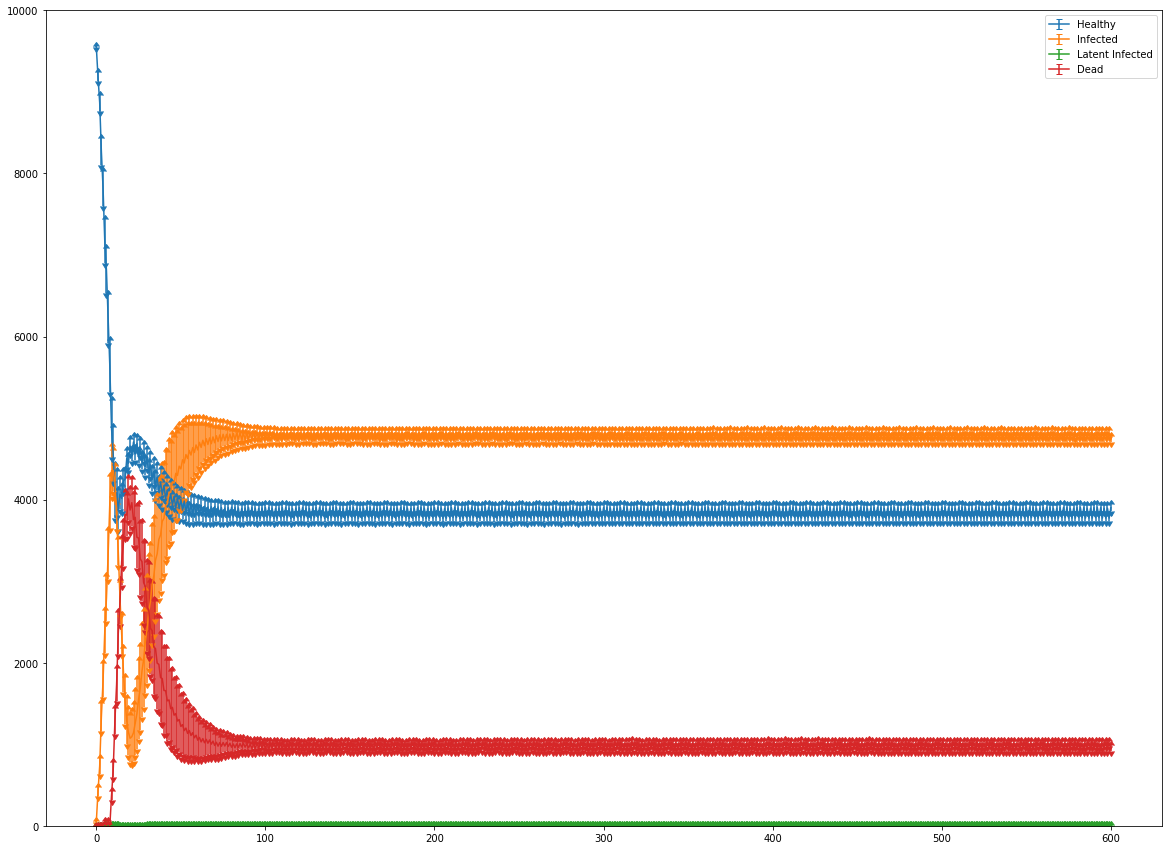

In [24]:
labels = ['Healthy', 'Infected', 'Latent Infected', 'Dead']
plt.figure(figsize=(20,15))
for i in range(4):
    plt.errorbar(range(601), averages[:,i], yerr=stdev[:,i], uplims=True, lolims=True, label=labels[i])
plt.legend(loc='upper right')
plt.ylim([0, 10000])
plt.show()